# Notebook 4: Applying the GPLVM to single-cell expression data from early embryonic development

The GrandPrix package implements the Bayesian GPLVM with or without an informative prior on the latent space (see [Ahmed, S., Rattray, M., & Boukouvalas, A. (2018). GrandPrix: Scaling up the Bayesian GPLVM for single-cell data. Bioinformatics, 35(1), 47-54.)](https://academic.oup.com/bioinformatics/article/35/1/47/5047752))

The original Bayesian GPLVM paper was introduced in Titsias, M., & Lawrence, N. D. (2010, March). Bayesian Gaussian process latent variable model. In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (pp. 844-851).

Notebook created by Sumon Ahmed, Magnus Rattray and Alexis Boukouvalas

For more notebooks exploring this and other single-cell datasets see https://github.com/ManchesterBioinference/GrandPrix

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from GrandPrix.GrandPrixModel import GrandPrixModel as GrandPrix

/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
def build_fit_and_getPosterior(m):
    m.build()
    m.fit()
    return m.get_latent_dims()

In [3]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [4]:
def plot_XY(X, Y, title, data_labels, label_order=None, **kwargs):
    if label_order is None:
        label_order = ['1', '2', '4', '8', '16', '32 ICM', '32 TE', '64 PE', '64 TE', '64 EPI']

    fsize = 16
    if 'fontsize' in kwargs:    fsize = kwargs.pop('fontsize')

    for l in label_order:
        plt.scatter(X[data_labels == l], Y[data_labels == l], 100, label=l)
        xPos = np.median(X[data_labels == l])
        yPos = np.median(Y[data_labels == l])
    xlabel = ''
    ylabel = ''
    if 'xlabel' in kwargs:  xlabel = kwargs.pop('xlabel')
    if 'ylabel' in kwargs:  ylabel = kwargs.pop('ylabel')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/20412781" target="_blank">Guo et al. (2010)</a> generated gene expression profiles of 48 genes measured across 437 cells. Cells differentiate from the single cell stage into three different cell states in the 64 cell stage: trophectoderm (TE), epiblast (EPI), and primitive endoderm (PE).

The "GuoData.csv" file contains the expression profiles of this dataset.

In [5]:
Y = pd.read_csv('data/GuoData.csv', index_col=[0])
N, D = Y.shape
print(N,D)

437 48


## Run PCA on the data

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(Y.values.copy())

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca.explained_variance_ratio_

array([0.32763464, 0.18134493, 0.08488334])

In [8]:
X_pca = pca.transform(Y)
X_pca.shape

(437, 3)

## We are going to build a sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mapping from the latent space to the data space using a Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__n_latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

## First fit a standard GPLVM, without an informative prior

In [9]:
latent_dims = 2
inducing_points = 40
X_var = 0.028

In [10]:
m = GrandPrix(data=Y.values, n_latent_dims=latent_dims,
              n_inducing_points=inducing_points, latent_var = X_var)

In [11]:
X_np,var_np = build_fit_and_getPosterior(m)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20216.900209
  Number of iterations: 539
  Number of functions evaluations: 595


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 20216.900209
  Number of iterations: 539
  Number of functions evaluations: 595


## Now fit the modified GPLVM with an informative prior

### We use developmental time to put a prior on the 1st latent space dimensions (the x-axis in the plots below) so that this dimension corresponds to pseudotime. The 2nd latent space dimension has an uninformative (zero-mean) prior for all cells and can pick up any other variation in the data. 

### We scale time to be linear in terms of cell division times and scale the data

In [12]:
def map_to_linear(t):
    if t == 1:
        return 0
    elif t == 2:
        return 1
    elif t == 4:
        return 2
    elif t == 8:
        return 3
    elif t == 16:
        return 4
    elif t == 32:
        return 5
    elif t == 64:
        return 6

In [13]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))
ct = np.zeros(N)
for il, l in enumerate(Y.index):
    s = l.split(' ')
    ct[il] = map_to_linear(int(s[0])) + 1
prior_mean = np.zeros((N, latent_dims))
prior_mean[:, 0] = ct
np.random.seed(1)
prior_var=0.5 # We explore the effect of changing the prior variance on pseudotime estimation 
              # in the Guo notebook here: https://github.com/ManchesterBioinference/GrandPrix

In [14]:
m_wp = GrandPrix(data=Y.values, n_latent_dims=latent_dims, n_inducing_points=inducing_points,
              latent_prior_mean=prior_mean, latent_prior_var=prior_var, latent_var=X_var)

In [15]:
X_wp,var_wp = build_fit_and_getPosterior(m_wp)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 19714.025854
  Number of iterations: 915
  Number of functions evaluations: 1032


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 19714.025854
  Number of iterations: 915
  Number of functions evaluations: 1032


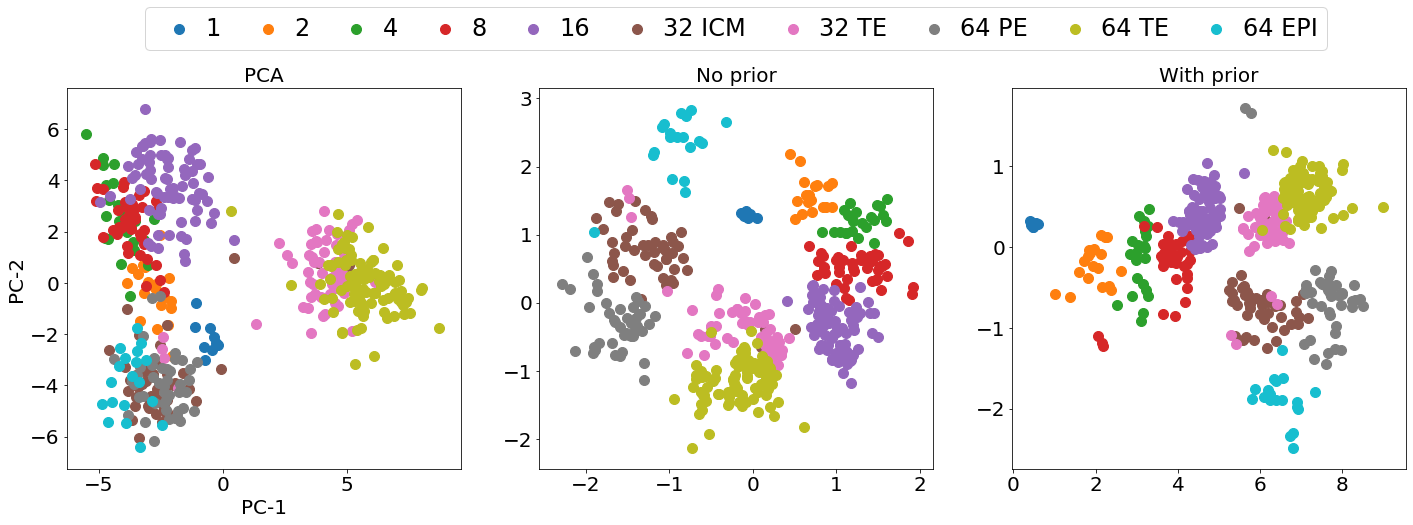

In [16]:
label_order = ['1', '2', '4', '8', '16', '32 ICM', '32 TE', '64 PE', '64 TE', '64 EPI']
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(24, 7))
plt.subplot(1, 3, 1)
plot_XY(X_pca[:,0], X_pca[:,1], 'PCA', Y.index, label_order, xlabel='PC-1', ylabel='PC-2')
plt.subplot(1, 3, 2)
plot_XY(X_np[:,0], X_np[:,1], 'No prior', Y.index, label_order)
plt.subplot(1, 3, 3)
plot_XY(X_wp[:,0], X_wp[:,1], 'With prior', Y.index, label_order)
plt.legend(bbox_to_anchor=(-2.2, 1.1, 3., 1.1), loc=3, ncol=10, mode="expand", borderaxespad=0., fontsize=24, frameon=True, fancybox=True, columnspacing=0.1, handletextpad=0.1)

## We can plot marker genes against the GPLVM dimension 1 (pseudotime) 
* _Id2_ - a known marker gene for TE, thus it behaves differently in TE cells from the other two differentiation stages.
* _Gata4_ - Gata4 is differentially expressed between the stages (PE and EPI) and between the stages (TE and PE).

The authors used k-means clustering to label the cell-types at the 32 and 64 cell stages and therefore we don't know for sure that the labelling is correct. We can see some differences in the 32TE and 32ICM cells from what we might expect for these marker genes, for example, suggesting there may be some issues with the labelling. 

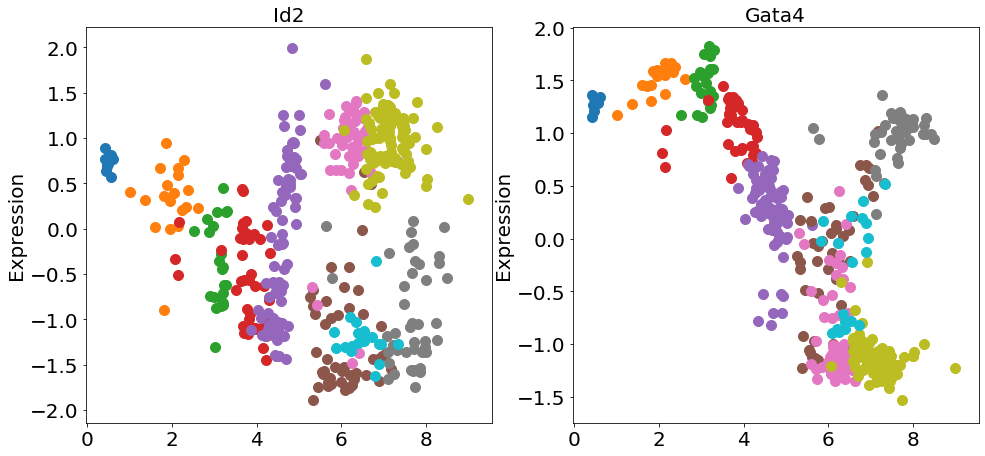

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 16))
plt.subplot(2, 2, 1)
plot_XY(X_wp[:,0], Y['Id2'], 'Id2', Y.index, ylabel='Expression')
plt.subplot(2, 2, 2)
plot_XY(X_wp[:,0], Y['Gata4'], 'Gata4', Y.index, ylabel='Expression')

## Expression profiles of 10 most differentially expressed genes between stages TE and EPI

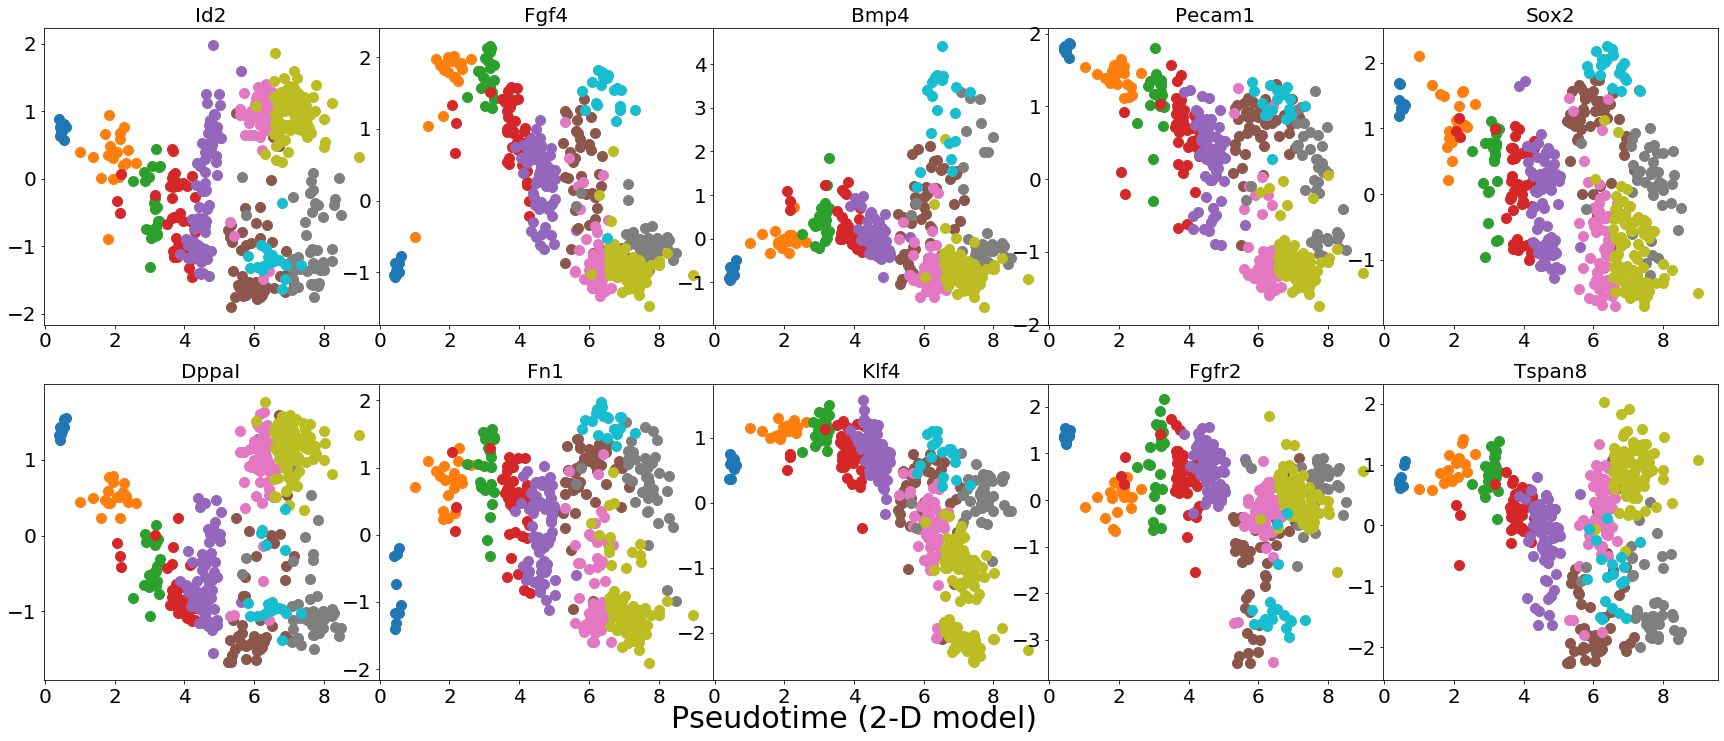

In [18]:
genes_TE_EPI = ['Id2', 'Fgf4', 'Bmp4', 'Pecam1', 'Sox2', 'DppaI', 'Fn1', 'Klf4', 'Fgfr2', 'Tspan8']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(X_wp[:,0], Y[genes_TE_EPI[g]], genes_TE_EPI[g], Y.index, xlabel='', ylabel='')
        g = g + 1

##  Expression profiles of 10 most differentially expressed genes between stages TE and PE

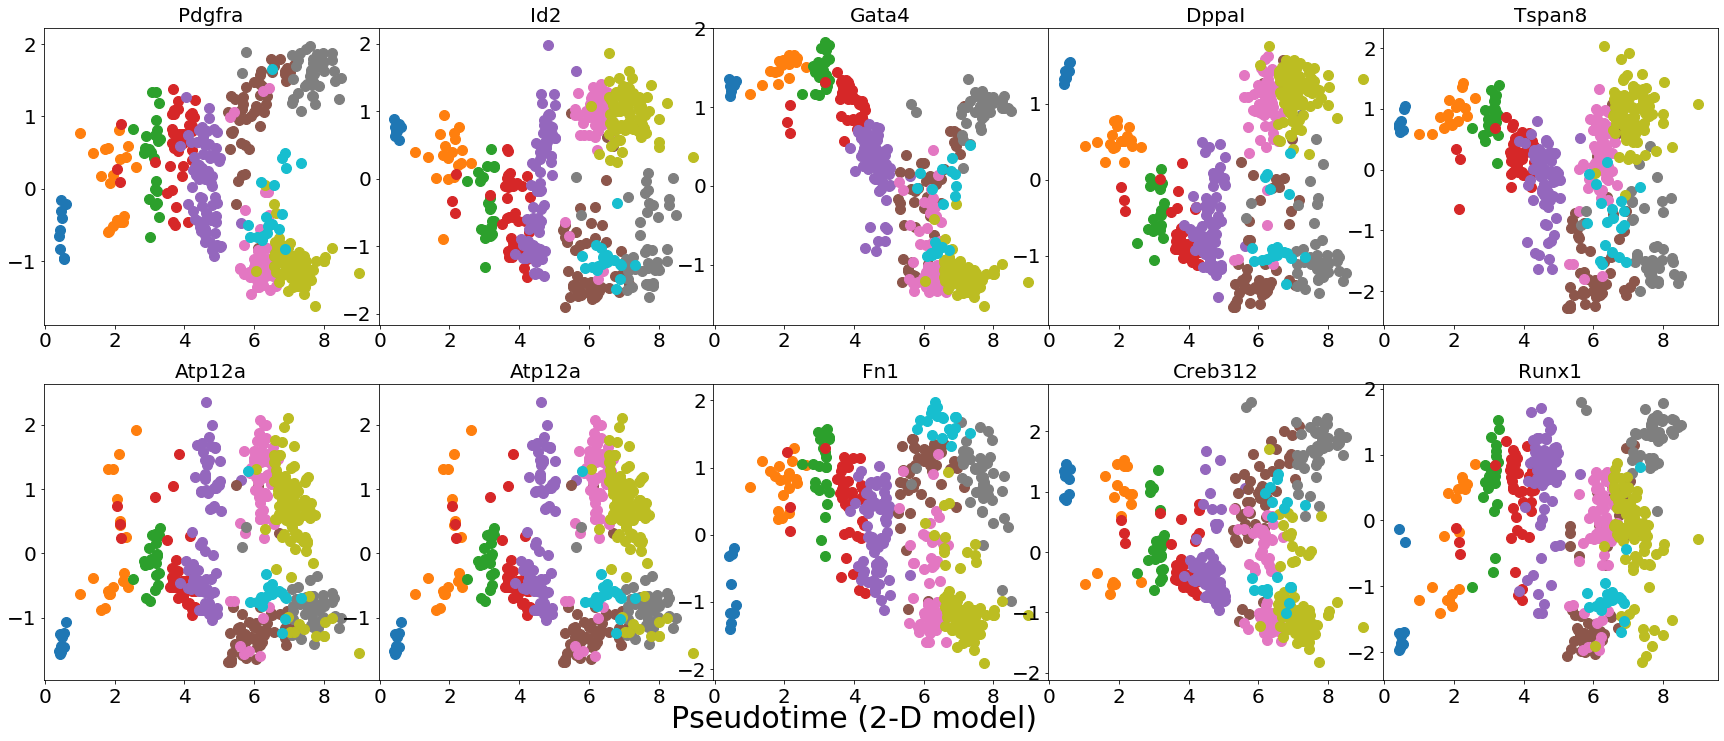

In [19]:
genes_TE_PE = ['Pdgfra', 'Id2', 'Gata4', 'DppaI', 'Tspan8', 'Atp12a', 'Atp12a', 'Fn1', 'Creb312', 'Runx1']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(X_wp[:,0], Y[genes_TE_PE[g]], genes_TE_PE[g], Y.index, xlabel='', ylabel='')
        g = g + 1

##  Expression profiles of 10 most differentially expressed genes between stages PE and EPI

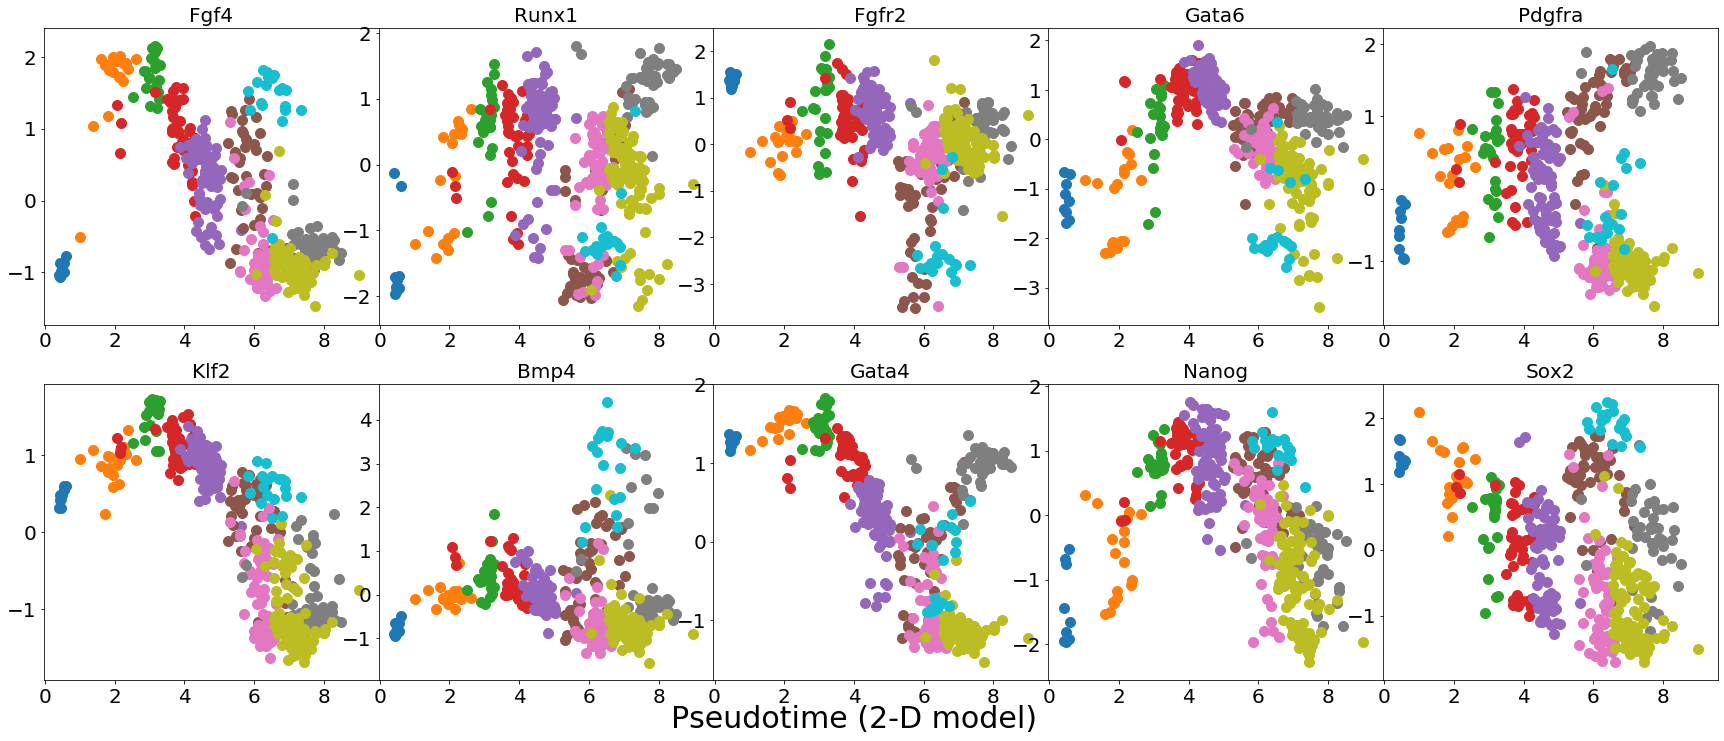

In [20]:
genes_PE_EPI = ['Fgf4', 'Runx1', 'Fgfr2', 'Gata6', 'Pdgfra', 'Klf2', 'Bmp4', 'Gata4', 'Nanog', 'Sox2']
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(30, 12))
fig.subplots_adjust(wspace=0)
fig.text(0.5, 0.08, 'Pseudotime (2-D model)', ha='center', va='center', fontsize=30)
g = 0
for row in ax:
    for col in row:
        plt.subplot(2, 5, g + 1)
        plot_XY(X_wp[:,0], Y[genes_PE_EPI[g]], genes_PE_EPI[g], Y.index, xlabel='', ylabel='')
        g = g + 1

## Exercises:

### 1) Investigate how changing the prior variance in the latent space affects the results of the GPLVM when using the informative prior.

### 2) PCA tries to find a linear low-dimensional projection of the data. Why do you think that approach fails to find a good 2D projection for this dataset? Try using PCA on only the data from the 64-cell stage - can it separate the cell-types? What does this tell us about the data? 

### 3) Investigate other non-linear dimensionality reduction methods available in scikit-learn on this dataset, e.g. tSNE is very popular for single-cell data